In [14]:
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Sequential, Model
import pandas as pd
import tarfile
import cv2
import os

In [2]:
ATTRS_NAME = "G:/encoders/lfw_attributes.txt"
IMAGES_NAME = "G:/encoders/lfw-deepfunneled.tgz"
RAW_IMAGES_NAME = "G:/encoders/lfw.tgz"

In [3]:

def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [10]:
def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # Read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t', skiprows=1)
    df_attrs = pd.DataFrame(df_attrs.iloc[:, :-1].values, columns=df_attrs.columns[1:])
    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # Read photos
    all_photos = []
    photo_ids = []

    # tqdm in used to show progress bar while reading the data in a notebook here, you can change
    # tqdm_notebook to use it outside a notebook
    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in (f.getmembers()):
            # Only process image files from the compressed data
            if m.isfile() and m.name.endswith(".jpg"):
                # Prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())

                # Crop only faces and resize it
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))

                # Parse person and append it to the collected data
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # Preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [15]:
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

In [16]:
X = X.astype('float32') / 255.0 - 0.5

def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

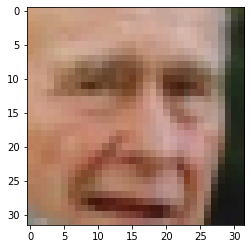

In [17]:
show_image(X[6])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

In [20]:

def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size,)))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))

    return encoder, decoder

IMG_SHAPE = X.shape[1:]
encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp,reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [21]:
print(autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32)                98336     
_________________________________________________________________
sequential_2 (Sequential)    (None, 32, 32, 3)         101376    
Total params: 199,712
Trainable params: 199,712
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
history = autoencoder.fit(x=X_train, y=X_train, epochs=20,
                validation_data=[X_test, X_test])


Instructions for updating:
Use tf.cast instead.
Train on 11828 samples, validate on 1315 samples
Epoch 1/20
11828/11828 [==============================] - ETA: 1:56 - loss: 0.049 - ETA: 10s - loss: 0.041 - ETA: 6s - loss: 0.0336 - ETA: 4s - loss: 0.028 - ETA: 3s - loss: 0.025 - ETA: 3s - loss: 0.023 - ETA: 2s - loss: 0.021 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.020 - ETA: 2s - loss: 0.019 - ETA: 2s - loss: 0.018 - ETA: 1s - loss: 0.018 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.017 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.016 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 1s - loss: 0.015 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.014 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.013 - ETA: 0s - loss: 0.012 - ETA: 0s - loss: 0.012 - 2

11828/11828 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 2s 145us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 10/20
11828/11828 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1

11828/11828 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 1s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - ETA: 0s - loss: 0.006 - 2s 154us/step - loss: 0.0067 - val_loss: 0.0066
Epoch 19/20
11828/11828 [==============================] - ETA: 2s - loss: 0.006 - ETA: 1

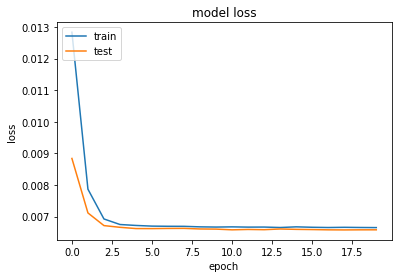

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:

def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    # img[None] will have shape of (1, 32, 32, 3) which is the same as the model input
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

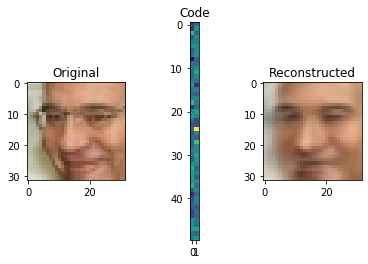

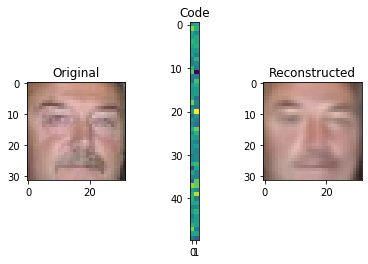

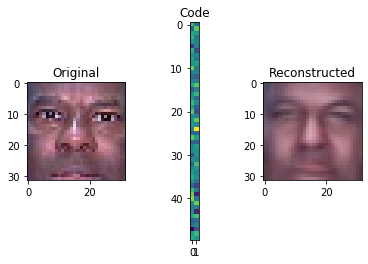

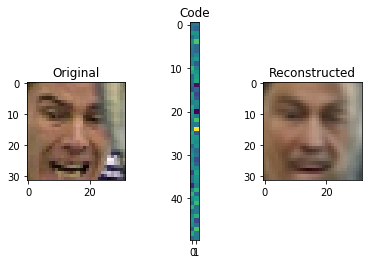

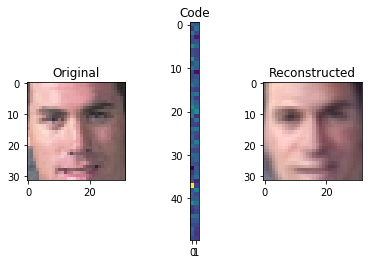

In [43]:
for i in range(5,10):
    img = X_test[i]
    visualize(img,encoder,decoder)

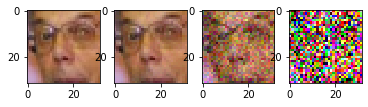

In [51]:
def apply_gaussian_noise(X, sigma=0.1):
    noise = np.random.normal(loc=0.0, scale=sigma, size=X.shape)
    return X + noise

plt.subplot(1,4,1)
show_image(X_train[1])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[1:],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[1:],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[1:],sigma=0.5)[0])

In [27]:

code_size = 100

# We can use bigger code size for better quality
encoder, decoder = build_autoencoder(IMG_SHAPE, code_size=code_size)

inp = Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

Epoch 1/25, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - ETA: 1:33 - loss: 0.048 - ETA: 28s - loss: 0.047 - ETA: 16s - loss: 0.04 - ETA: 12s - loss: 0.03 - ETA: 10s - loss: 0.03 - ETA: 9s - loss: 0.0297 - ETA: 8s - loss: 0.027 - ETA: 7s - loss: 0.026 - ETA: 7s - loss: 0.025 - ETA: 7s - loss: 0.024 - ETA: 6s - loss: 0.023 - ETA: 6s - loss: 0.022 - ETA: 6s - loss: 0.022 - ETA: 6s - loss: 0.021 - ETA: 5s - loss: 0.021 - ETA: 5s - loss: 0.020 - ETA: 5s - loss: 0.020 - ETA: 5s - loss: 0.020 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.019 - ETA: 5s - loss: 0.018 - ETA: 5s - loss: 0.018 - ETA: 4s - loss: 0.018 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.017 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 4s - loss: 0.016 - ETA: 3s - loss: 0.015 - ETA: 3

11828/11828 [==============================] - ETA: 5s - loss: 0.004 - ETA: 6s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0.004 - ETA: 3s - loss: 0

11828/11828 [==============================] - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.004 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 4s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 5s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 5s - loss: 0.004 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0.003 - ETA: 2s - loss: 0

11828/11828 [==============================] - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 4s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0.003 - ETA: 3s - loss: 0

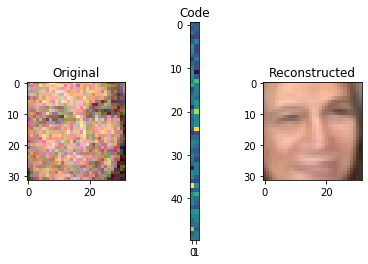

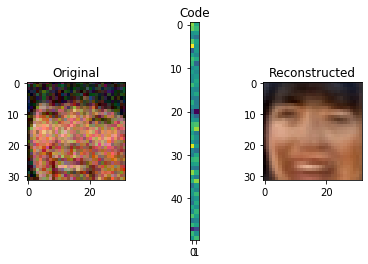

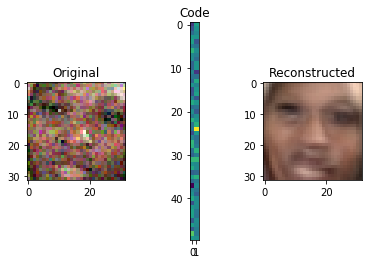

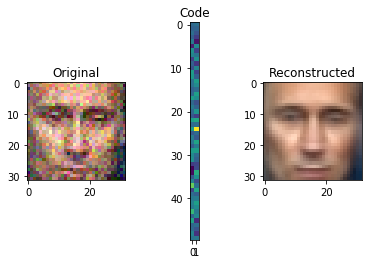

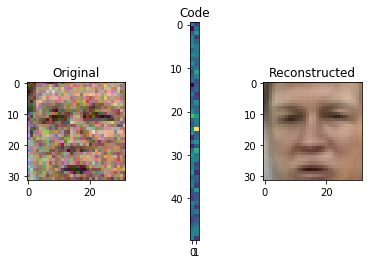

In [28]:
for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)

    # We continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test])

X_test_noise = apply_gaussian_noise(X_test)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

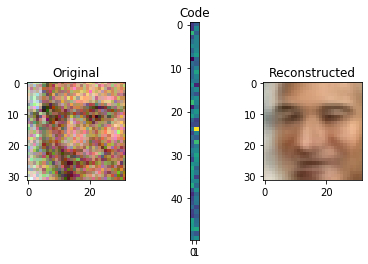

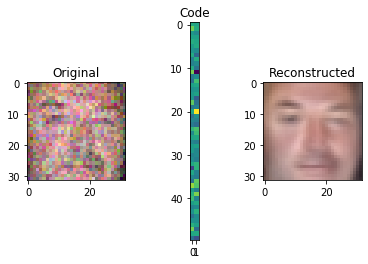

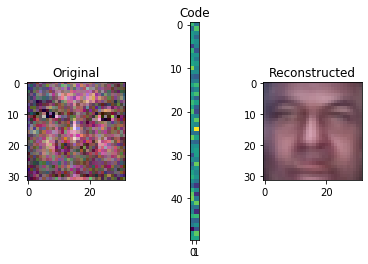

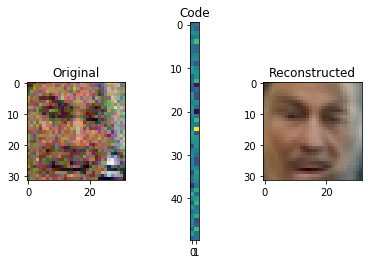

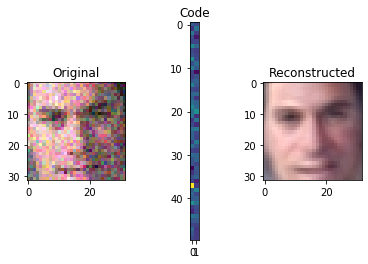

In [52]:
X_test_noise = apply_gaussian_noise(X_test)
for i in range(5,10):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)